In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


Epoch 10, Gen Loss: 0.6599537134170532, Disc Loss: 1.385756492614746
Epoch 20, Gen Loss: 0.6766806840896606, Disc Loss: 1.3862216472625732
Epoch 30, Gen Loss: 0.6729527115821838, Disc Loss: 1.3831231594085693
Epoch 40, Gen Loss: 0.6913565397262573, Disc Loss: 1.379248857498169
Epoch 50, Gen Loss: 0.6914282441139221, Disc Loss: 1.3863513469696045
Epoch 60, Gen Loss: 0.9094873666763306, Disc Loss: 1.2629053592681885
Epoch 70, Gen Loss: 0.7501626014709473, Disc Loss: 1.3084245920181274
Epoch 80, Gen Loss: 0.7128086090087891, Disc Loss: 1.3569514751434326
Epoch 90, Gen Loss: 0.7138501405715942, Disc Loss: 1.3992581367492676
Epoch 100, Gen Loss: 0.6625598669052124, Disc Loss: 1.4464787244796753
Epoch 110, Gen Loss: 0.6797434091567993, Disc Loss: 1.4362308979034424
Epoch 120, Gen Loss: 0.673662543296814, Disc Loss: 1.4531528949737549
Epoch 130, Gen Loss: 0.7197552919387817, Disc Loss: 1.4008018970489502
Epoch 140, Gen Loss: 0.7153249979019165, Disc Loss: 1.3671932220458984
Epoch 150, Gen Los

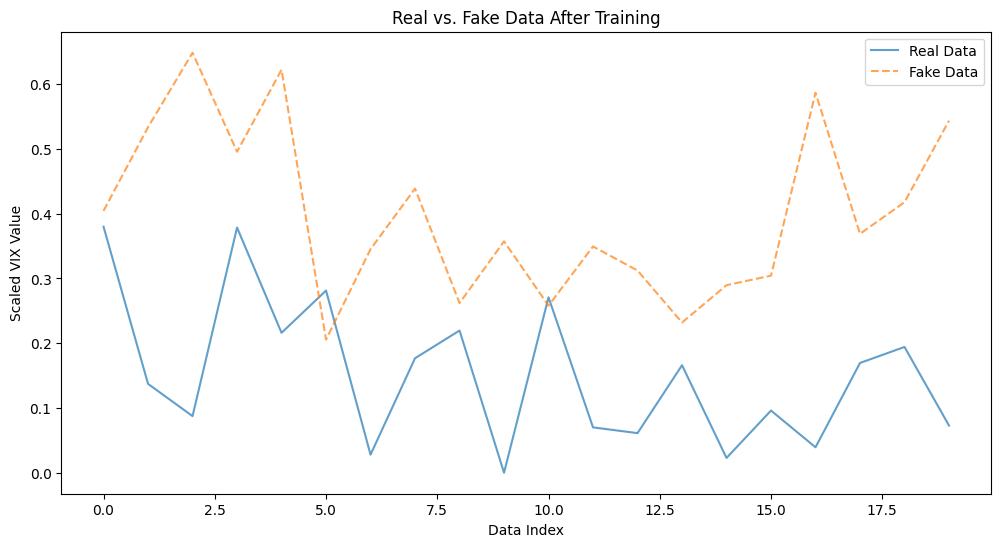

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = 'VIX.csv'
vix_data = pd.read_csv(data_path)
vix_values = vix_data['VIX'].values.reshape(-1, 1)

scaler = MinMaxScaler()
vix_values_scaled = scaler.fit_transform(vix_values)

# Convert VIX data to TensorFlow Dataset
BUFFER_SIZE = len(vix_values_scaled)
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(vix_values_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator is very simple only with dense layers since its a linear GAN model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(200, use_bias=True),
        layers.Dense(400, use_bias=True),
        layers.Dense(800, use_bias=True),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# discriminator is very simple only with dense layers since its a linear GAN model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(800, use_bias=True),
        layers.Dense(400, use_bias=True),
        layers.Dense(200, use_bias=True),
        layers.Dense(1)
    ])
    return model

# Define loss as BCE
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Setup the models and optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #Adam optimizer
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step function
def train_step(real_data):
    noise_dim = 100
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, gen_loss, real_data, generated_data

#main Training function :
def train(dataset, epochs):
    real_samples_plot = []
    fake_samples_plot = []
    for epoch in range(epochs):
        for data_batch in dataset:
            disc_loss, gen_loss, real_data, generated_data = train_step(data_batch)
        # Collect real and fake samples for the final plot
        real_samples_plot.extend(real_data.numpy().flatten())
        fake_samples_plot.extend(generated_data.numpy().flatten())

        # Print loss  every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

       # Define the range of indices to display
    display_start_index = 0  # Start index of the sample to display
    display_end_index = 20  # End index of the sample to display

    #We've chosen an arbitrary start and stop index because it makes visual inspection easier,
    #because our goal is to find the model which can generated data the best (as similar to the real data as possible)

    plt.figure(figsize=(12, 6))
    plt.plot(real_samples_plot[display_start_index:display_end_index], label='Real Data', alpha=0.7)
    plt.plot(fake_samples_plot[display_start_index:display_end_index], label='Fake Data', alpha=0.7, linestyle='--')

    plt.title('Real vs. Fake Data After Training')
    plt.xlabel('Data Index')
    plt.ylabel('Scaled VIX Value')
    plt.legend()
    plt.show()

# Start training
EPOCHS = 200
train(train_dataset, EPOCHS)
